# DeepEthogram: biological behavior classification from raw pixels

**Abstract**: Videos of animal behavior are used to quantify researcher-defined behaviors-of-interest to study neural function, gene mutations, and pharmacological therapies. Behaviors-of-interest are often scored manually, which is time-consuming, limited to few behaviors, and variable across researchers. We created DeepEthogram: software that uses supervised machine learning to convert raw video pixels into an ethogram, the behaviors-of-interest present in each video frame. DeepEthogram is designed to be general-purpose, applicable across species, behaviors, and video-recording hardware. It uses convolutional neural networks to compute motion, extract features from motion and images, and classify features into behaviors. Behaviors are classified with greater than 90% accuracy on single frames in videos of mice and flies, matching expert-level human performance. DeepEthogram accurately predicts rare behaviors, requires little training data, and generalizes across subjects. A graphical interface allows beginning-to-end analysis without end-user programming. DeepEthogram’s rapid, automatic, and reproducible labeling of researcher-defined behaviors-of-interest may accelerate and enhance supervised behavior analysis.

<figure>
<center>
<img src='https://pbs.twimg.com/media/Eixgo58XsAIZtTp?format=jpg&name=small' />
<figcaption>DeepEthogram summary</figcaption></center>
</figure>

Example use cases:


*   Quantifying face vs body grooming in the open field
*   Measuring bout durations of itching behavior
*   Counting licks using pure video, no infrared-beam-crossing or hardware circuit required

## This notebook
This Colab notebook will show you how to train all DeepEthogram models using code (not the GUI or the command line interface).

**Because we aren't using the GUI, you will need to install DeepEthogram on your computer (even if it does not have a GPU) and label at least 3 videos. Then, you can upload them to Google Drive and run this notebook!**

### This notebook will:
* Show you how to train models and run inference using the code
* Show you how to edit your configurations to run experiments
* Include command-line-equivalent arguments, so you can learn to use the CLI
* Actually train models and run inference on your data

### This notebook won't:
* let you use the GUI or label data
* be very fast (due to low numbers of CPU workers, and often old GPUs)
* let you easily run inference, fix the errors, and then re-train. For that you'll need a local machine, or you need to upload every new video and download every video's new inference files.

## Workflow

As noted in the DeepEthogram paper, the overall workflow is as follows:

* Train the flow generator. Only really needs to happen once if you start with >10 decently sized videos. You can re-train if you get lots more data, or if you change the recording conditions: this can include color, resolution, background, arena type, etc.
* Train the feature extractor
* Run inference using the feature extractor. This will save the image features, as well as our intermediate probabilities for each behavior, to disk, in an HDF5 file.
* Now that we have our image features (two vectors for each video frame), we train a sequence model-- these have much longer receptive fields, so the outputs will be smoother than the feature extractor outputs. We also find that performance improves.
* Now that we have a trained sequence model, run inference using the sequence model.
* Finally, since we have the probabilities for each frame, we need to postprocess these probabilities into binary predictions.

## Upload your data
For this demo, we need to upload our data to Google Drive. If you used the GUI to label your videos, please upload the full project folder. If you didn't, you should make sure that the project folder has the structure noted in [this document](https://github.com/jbohnslav/deepethogram/blob/master/docs/file_structure.md).

In my case, I uploaded the project named `testing_deepethogram` to my `My Drive/Public` directory.

Some notes on space and performance:


*   Video files can take up a lot of space. See if you can use your lab's Google account, which might have more storage; alternatively, you can pay to get more storage on your drive.
*   The limiting factor in DeepEthogram performance, if you are lucky enough to get a fast GPU on Colab, will be reading from disk. Converting your video to a file format that enables faster random reading will improve this, but it will use up even more space! [Please read this document for detailed information, including instructions for how (and why) to convert your videos to a different format](https://github.com/jbohnslav/deepethogram/blob/master/docs/performance.md).
*    Detailed note: for Google Drive, directories of PNGs will be extremely slow to upload (`movie_format='directory'`); therefore, I recommend converting your videos using `movie_format='hdf5'`.



# Setup

## install deepethogram
Run this cell to install DeepEthogram on this particular compute node. We will use `pip` for installation. We have to uninstall `torchtext`, as this causes issues with Pytorch Lightning.

In [ ]:
!pip uninstall -y opencv-python
!pip install --upgrade deepethogram
# this is for pytorch lightning compatibility
!pip uninstall -y torchtext

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached deepethogram-0.1.4-py3-none-any.whl (316 kB)
     |████████████████████████████████| 47.8 MB 73 kB/s 
     |████████████████████████████████| 164.3 MB 57 kB/s 
  Using cached pytorch_lightning-1.6.4-py3-none-any.whl (585 kB)
     |████████████████████████████████| 512 kB 64.2 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 117 kB 74.6 MB/s 
     |████████████████████████████████| 596 kB 56.8 MB/s 
     |████████████████████████████████| 418 kB 59.3 MB/s 
     |████████████████████████████████| 140 kB 67.4 MB/s 
     |████████████████████████████████| 1.1 MB 53.1 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 144 kB 67.5 MB/s 
    

Found existing installation: torchtext 0.12.0
Uninstalling torchtext-0.12.0:
  Successfully uninstalled torchtext-0.12.0


## Change to a GPU runtime
After installation, we will want a GPU to train models. Please go up to the `Runtime` tab and hit `change runtime type` and select `GPU`. After that, go up and click `restart runtime`.

## Imports
Run the following cell to import all the modules we need.

In [ ]:
import logging
import multiprocessing
import os
import random

from google.colab import drive
import h5py
# not used in DeepEthogram; only to easily show plots
from IPython.display import Image
from omegaconf import OmegaConf
import pandas as pd
import torch

from deepethogram import configuration, postprocessing, projects, utils
from deepethogram.debug import print_dataset_info
from deepethogram.flow_generator.train import flow_generator_train
from deepethogram.feature_extractor.train import feature_extractor_train
from deepethogram.feature_extractor.inference import feature_extractor_inference
from deepethogram.sequence.train import sequence_train
from deepethogram.sequence.inference import sequence_inference

In [ ]:
# Make sure we actually have a GPU
print(torch.__version__)
print('gpu available: {}'.format(torch.cuda.is_available()))
print('gpu name: {}'.format(torch.cuda.get_device_name(0)))

assert torch.cuda.is_available(), 'Please select a GPU runtime and then restart!'

1.11.0+cu113
gpu available: True
gpu name: Tesla T4


## Mount your Drive and find your data

Use the following cell to mount your Google drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Where exactly your data is depends on where you uploaded it. For me, my project directory is `MyDrive/Public/testing_deepethogram`. Use this cell to list the files within it.

In [ ]:
!ls -lah /content/drive/MyDrive/Public/testing_deepethogram

total 103K
drwx------ 2 root root 4.0K Jun  2  2021 DATA
-rw------- 1 root root  94K Jun  4  2021 deepethogram_abstract.jpeg
drwx------ 2 root root 4.0K Jun  2  2021 models
-rw------- 1 root root  871 Jun  3  2021 project_config.yaml


## Set our project path
This path is used by DeepEthogram all over the place to find your custom project configuration, to know where your data and models are, and to save new models. Change this project path to your actual path.

This cell also checks to make sure the essential directories are there.

In [ ]:
project_path = '/content/drive/MyDrive/Public/testing_deepethogram'
files = os.listdir(project_path)
assert 'DATA' in files, 'DATA directory not found! {}'.format(files)
assert 'models' in files, 'models directory not found! {}'.format(files)
assert 'project_config.yaml' in files, 'project config not found! {}'.format(files)

## dataset info

Now, let's print some information to see how big our dataset is. First, we make a little function to reset our logger; logging gets changed by our training runs, so we'll want to reset it afterward.

In [ ]:
def reset_logger():
  # First, overwrite any logger so that we can actually see log statements
  # https://stackoverflow.com/questions/13839554/how-to-change-filehandle-with-python-logging-on-the-fly-with-different-classes-a
  log = logging.getLogger()  # root logger
  log.setLevel(logging.INFO)
  for hdlr in log.handlers[:]:  # remove all old handlers
      log.removeHandler(hdlr)
  log.addHandler(logging.StreamHandler())
  return log

In [ ]:
log = reset_logger()

print_dataset_info(os.path.join(project_path, 'DATA'))

Information about subdir mouse00
Video: /content/drive/MyDrive/Public/testing_deepethogram/DATA/mouse00/mouse00.h5
Labels with counts: [  2 277  21   0   0]
Information about subdir mouse01
Video: /content/drive/MyDrive/Public/testing_deepethogram/DATA/mouse01/mouse01
Labels with counts: [283   0   0  17   0]
Information about subdir mouse02
Video: /content/drive/MyDrive/Public/testing_deepethogram/DATA/mouse02/mouse02.avi
Labels with counts: [300   0   0   0   0]
Information about subdir mouse03
Video: /content/drive/MyDrive/Public/testing_deepethogram/DATA/mouse03/mouse03.h5
Labels with counts: [99  0  0  0  0]
Information about subdir mouse04
Video: /content/drive/MyDrive/Public/testing_deepethogram/DATA/mouse04/mouse04.avi
Labels with counts: [  3  56 241   0   0]
Information about subdir mouse05
Video: /content/drive/MyDrive/Public/testing_deepethogram/DATA/mouse05/mouse05.mp4
Labels with counts: [286  14   0   0   0]
Information about subdir mouse06
Video: /content/drive/MyDrive/

We can see that this test dataset only has 7 videos with 300 frames each. We're not expecting good performance here-- this dataset was only created for automatic testing.

# Train Flow Generator and Feature Extractor models

The flow generator is the model that computes frame-to-frame motion; the feature extractors are the big models that learn to compress the image into a set of low-dimensional vectors (relatively small lists of numbers) that represent the behaviors in the image.

<figure>
<center>
<img src='https://github.com/jbohnslav/deepethogram/blob/master/docs/images/deepethogram_schematic.png?raw=true' />
<figcaption>The flow generator is schematized on the left: the feature extractors are in the center.
</figcaption></center>
</figure>

For this notebook we'll be using the `deg_f` preset; this is the fastest and lightest-weight model.

We will use the `deepethogram.configuration` module to make a configuration for each major task; training and inference. This module combines various configurations together; for example, we re-use the image augmentation configuration for training both feature extractor and flow generator models, but not for running inference.

Run this cell to make a flow generator `cfg` and print it.

In [ ]:
preset = 'deg_f'
cfg = configuration.make_flow_generator_train_cfg(project_path, preset=preset)
print(OmegaConf.to_yaml(cfg))

split:
  reload: true
  file: null
  train_val_test:
  - 0.8
  - 0.2
  - 0.0
compute:
  fp16: false
  num_workers: 8
  batch_size: 32
  min_batch_size: 8
  max_batch_size: 512
  distributed: false
  gpu_id: 0
  dali: false
  metrics_workers: 0
reload:
  overwrite_cfg: false
  latest: false
notes: null
log:
  level: info
augs:
  brightness: 0.25
  contrast: 0.1
  hue: 0.1
  saturation: 0.1
  color_p: 0.5
  grayscale: 0.5
  crop_size: null
  resize:
  - 224
  - 224
  dali: false
  random_resize: false
  pad: null
  LR: 0.5
  UD: 0.5
  degrees: 10
  normalization:
    'N': 13125000
    mean:
    - 0.02004539966386554
    - 0.03199181684407095
    - 0.025961602390289447
    std:
    - 0.02522799020705389
    - 0.05607626687605602
    - 0.03893020334412448
train:
  lr: 0.0001
  scheduler: plateau
  num_epochs: 10
  steps_per_epoch:
    train: 1000
    val: 200
    test: 20
  min_lr: 5.0e-07
  stopping_type: learning_rate
  milestones:
  - 50
  - 100
  - 150
  - 200
  - 250
  - 300
  weight_

Now that we have our fully-made configuration in memory, we can edit whatever we'd like. Because my particular node only has 2 cpus, we will change our "num workers" for the dataloader to be 2. You can use this same technique-- editing the configuration object in memory-- to play with parameters and see if you can get model performance to improve. Note that there aren't a lot of training wheels here-- you might run into errors if you change the wrong parameter!

In [ ]:
n_cpus = multiprocessing.cpu_count()

print('n cpus: {}'.format(n_cpus))
cfg.compute.num_workers = n_cpus

n cpus: 2


This cell will actually train the flow generator model. Note that because we have a slow GPU and only 2 CPU workers, it will take a long time. However, whenever we feel like, we can interrupt this cell and the model will still save.

**equivalent command line arguments:** `python -m deepethogram.flow_generator.train compute.num_workers=2 project.path=/content/drive/MyDrive/Public/testing_deepethogram`

In [ ]:
flow_generator = flow_generator_train(cfg)

[2022-06-08 00:57:11,306] INFO [deepethogram.projects.convert_config_paths_to_absolute:1135] cwd in absolute: /content
[2022-06-08 00:57:11,312] INFO [deepethogram.projects.convert_config_paths_to_absolute:1178] after absolute: {'class_names': ['background', 'face_groom', 'body_groom', 'dig', 'scratch'], 'config_file': '/content/drive/MyDrive/Public/testing_deepethogram/project_config.yaml', 'data_path': '/content/drive/MyDrive/Public/testing_deepethogram/DATA', 'labeler': None, 'model_path': '/content/drive/MyDrive/Public/testing_deepethogram/models', 'name': 'testing', 'path': '/content/drive/MyDrive/Public/testing_deepethogram', 'pretrained_path': '/content/drive/MyDrive/Public/testing_deepethogram/models/pretrained_models'}
[2022-06-08 00:57:11,363] INFO [deepethogram.flow_generator.train.flow_generator_train:54] args: /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-0e1fd471-25c4-4c9b-b572-451c03cad8a8.json
[2022-06-08 00:57

reloading weights...


[2022-06-08 00:57:32,110] INFO [deepethogram.flow_generator.train.get_metrics:364] key metric is SSIM
[2022-06-08 00:57:32,152] INFO [torch.distributed.nn.jit.instantiator.<module>:21] Created a temporary directory at /tmp/tmpad12845v
[2022-06-08 00:57:32,155] INFO [torch.distributed.nn.jit.instantiator._write:76] Writing /tmp/tmpad12845v/_remote_module_non_sriptable.py
[2022-06-08 00:57:32,185] INFO [deepethogram.data.augs.get_gpu_transforms:246] GPU transforms: {'train': Sequential(
  (0): ToFloat()
  (1): VideoSequential(
    (RandomHorizontalFlip_0): RandomHorizontalFlip(RandomHorizontalFlip(p=0.5, p_batch=1.0, same_on_batch=False))
    (RandomVerticalFlip_1): RandomVerticalFlip(RandomVerticalFlip(p=0.5, p_batch=1.0, same_on_batch=False))
    (RandomRotation_2): RandomRotation(RandomRotation(degrees=10, p=0.5, p_batch=1.0, same_on_batch=False, resample=bilinear, align_corners=True))
    (ColorJitter_3): ColorJitter(ColorJitter(brightness=0.25, contrast=0.1, saturation=0.1, hue=0.1,

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `fu

{} {}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

{} {}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Evaluate our flow generator

During training, our flow generator models are constantly evaluated. You can navigate to your project directory, then to `models`. You should see a folder called `XXXXX_flow_generator_train` from our most recent training run. That directory has a `figures` directory, where you can look at various evaluations of our model.

Alternatively, you can run this cell to find the latest model directory, load our learning curves figure, and plot it.

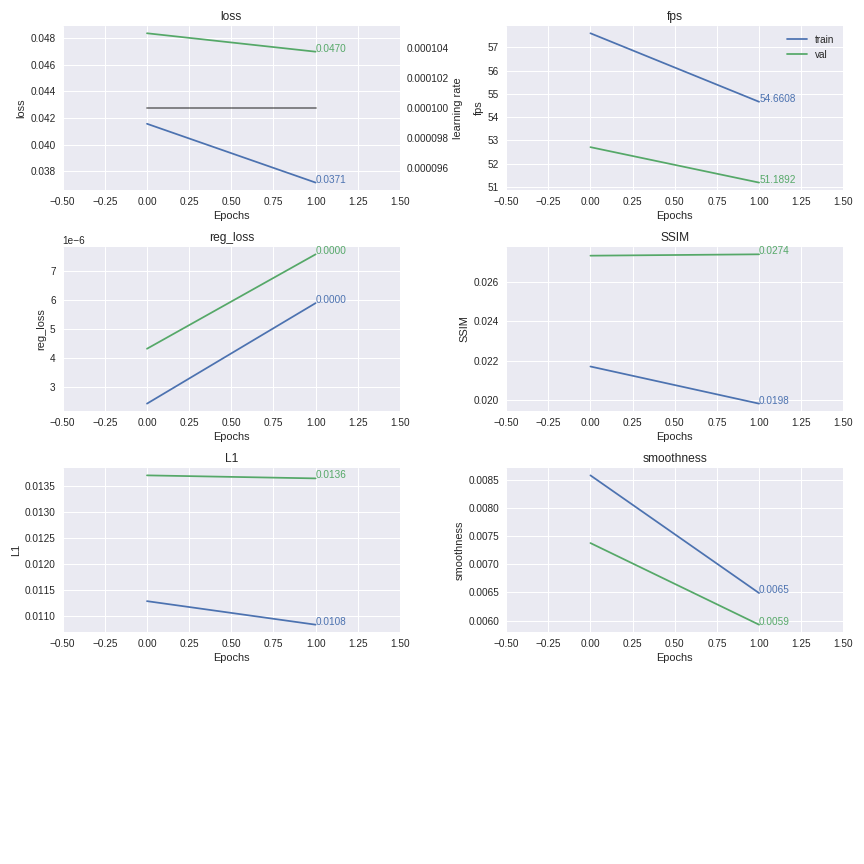

In [ ]:
model_path = os.path.join(project_path, 'models')
weights = projects.get_weights_from_model_path(model_path)
flow_weights = weights['flow_generator']
# because we used deg_f, our model type is a TinyMotionNet
latest_weights = flow_weights['TinyMotionNet'][-1]
# our run directory is two steps above the weight file
run_dir = os.path.dirname(os.path.dirname(latest_weights))
assert os.path.isdir(run_dir), 'run directory not found! {}'.format(run_directory)

figure_dir = os.path.join(run_dir, 'figures')
figure_files = utils.get_subfiles(figure_dir, 'file')
assert len(figure_files) == 1

Image(figure_files[0])

## Train feature extractor

Now that we have an optic flow model customized to our dataset. The steps for training the feature extractor are the same; load up a configuration, edit the config, and train the model.

In [ ]:
cfg = configuration.make_feature_extractor_train_cfg(project_path, preset=preset)
print(OmegaConf.to_yaml(cfg))

split:
  reload: true
  file: null
  train_val_test:
  - 0.8
  - 0.2
  - 0.0
compute:
  fp16: false
  num_workers: 8
  batch_size: 32
  min_batch_size: 8
  max_batch_size: 512
  distributed: false
  gpu_id: 0
  dali: false
  metrics_workers: 0
reload:
  overwrite_cfg: false
  latest: false
notes: null
log:
  level: info
augs:
  brightness: 0.25
  contrast: 0.1
  hue: 0.1
  saturation: 0.1
  color_p: 0.5
  grayscale: 0.5
  crop_size: null
  resize:
  - 224
  - 224
  dali: false
  random_resize: false
  pad: null
  LR: 0.5
  UD: 0.5
  degrees: 10
  normalization:
    'N': 13125000
    mean:
    - 0.02004539966386554
    - 0.03199181684407095
    - 0.025961602390289447
    std:
    - 0.02522799020705389
    - 0.05607626687605602
    - 0.03893020334412448
train:
  lr: 0.0001
  scheduler: plateau
  num_epochs: 20
  steps_per_epoch:
    train: 1000
    val: 1000
    test: null
  min_lr: 5.0e-07
  stopping_type: learning_rate
  milestones:
  - 50
  - 100
  - 150
  - 200
  - 250
  - 300
  weig

Notice that by default, the flow generator weights are `pretrained`, which means it was trained on Kinetics700. We want it instead to use our custom flow generator weights, so let's edit the configuration.

In [ ]:
# the latest string will find the most recent model by date
# you can also pass a specific .pt or .ckpt file here
cfg.flow_generator.weights = 'latest'
cfg.compute.num_workers = n_cpus

Now we actually train!

**equivalent command line arguments:** `python -m deepethogram.feature_extractor.train compute.num_workers=2 project.path=/content/drive/MyDrive/Public/testing_deepethogram flow_generator.weights=latest`

In [ ]:
log = reset_logger()

feature_extractor = feature_extractor_train(cfg)

[2022-06-08 01:03:27,547] INFO [deepethogram.projects.convert_config_paths_to_absolute:1135] cwd in absolute: /content/drive/MyDrive/Public/testing_deepethogram/models/220608_005711_flow_generator_train
[2022-06-08 01:03:27,554] INFO [deepethogram.projects.convert_config_paths_to_absolute:1178] after absolute: {'class_names': ['background', 'face_groom', 'body_groom', 'dig', 'scratch'], 'config_file': '/content/drive/MyDrive/Public/testing_deepethogram/project_config.yaml', 'data_path': '/content/drive/MyDrive/Public/testing_deepethogram/DATA', 'labeler': None, 'model_path': '/content/drive/MyDrive/Public/testing_deepethogram/models', 'name': 'testing', 'path': '/content/drive/MyDrive/Public/testing_deepethogram', 'pretrained_path': '/content/drive/MyDrive/Public/testing_deepethogram/models/pretrained_models'}
[2022-06-08 01:03:27,580] INFO [deepethogram.feature_extractor.train.feature_extractor_train:66] args: /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f /root/.loca

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `fu

{} {}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

{} {}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Evaluate our feature extractor
A huge amount of the effort of the DeepEthogram code and paper was evaluating the model performance. As a very simple window, we will do what we did above and load the automatically generated figure files. You can also browse to the location in your Google drive and look at all the images.

Note that we are not expecting good performance here, at all. With only a few hundred training images, there are likely less than 100 training examples for each behavior that we care about (see Dataset info above).

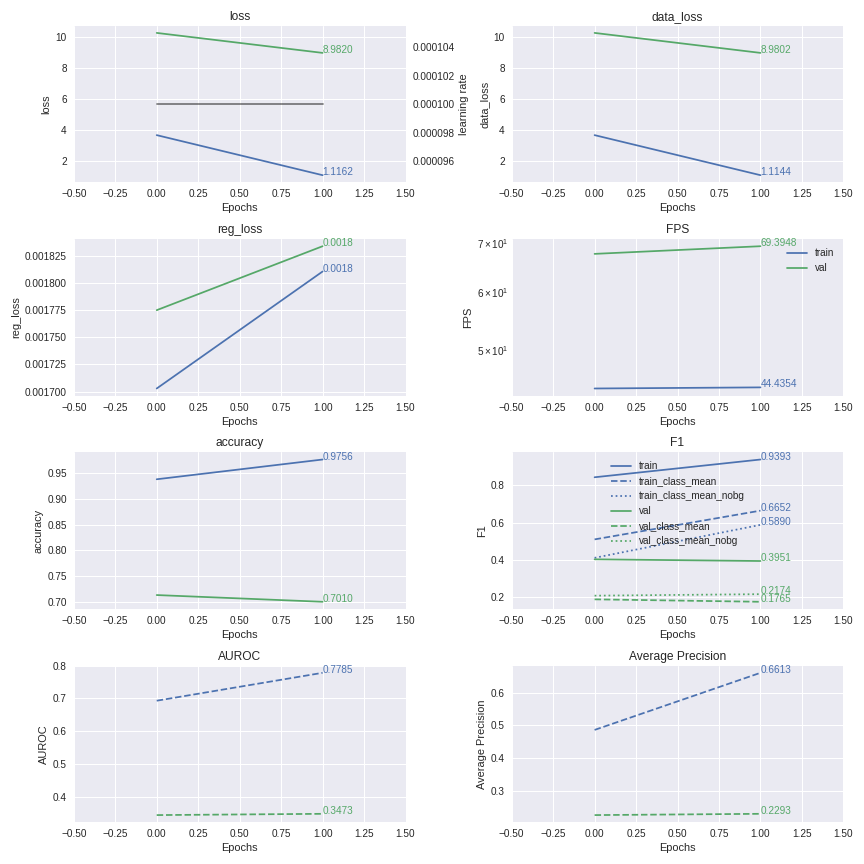

In [ ]:
model_path = os.path.join(project_path, 'models')
weights = projects.get_weights_from_model_path(model_path)
flow_weights = weights['feature_extractor']
# because we used deg_f, our model type is a resnet18
latest_weights = flow_weights['resnet18'][-1]
# our run directory is two steps above the weight file
run_dir = os.path.dirname(os.path.dirname(latest_weights))
assert os.path.isdir(run_dir), 'run directory not found! {}'.format(run_directory)

figure_dir = os.path.join(run_dir, 'figures')
figure_files = utils.get_subfiles(figure_dir, 'file')
assert len(figure_files) >= 1

Image(figure_files[0])

# Run inference

As noted in the Workflow section, we now need to save image features and optic flow features for every frame to disk. This is done in the same way; with a configuration that we can manually edit.

In [ ]:
cfg = configuration.make_feature_extractor_inference_cfg(project_path=project_path, preset=preset)
print(OmegaConf.to_yaml(cfg))

split:
  reload: true
  file: null
  train_val_test:
  - 0.8
  - 0.2
  - 0.0
compute:
  fp16: false
  num_workers: 8
  batch_size: 32
  min_batch_size: 8
  max_batch_size: 512
  distributed: false
  gpu_id: 0
  dali: false
  metrics_workers: 0
reload:
  overwrite_cfg: false
  latest: false
notes: null
log:
  level: info
augs:
  brightness: 0.25
  contrast: 0.1
  hue: 0.1
  saturation: 0.1
  color_p: 0.5
  grayscale: 0.5
  crop_size: null
  resize:
  - 224
  - 224
  dali: false
  random_resize: false
  pad: null
  LR: 0.5
  UD: 0.5
  degrees: 10
  normalization:
    'N': 13125000
    mean:
    - 0.02004539966386554
    - 0.03199181684407095
    - 0.025961602390289447
    std:
    - 0.02522799020705389
    - 0.05607626687605602
    - 0.03893020334412448
feature_extractor:
  arch: resnet18
  fusion: average
  sampler: null
  final_bn: false
  sampling_ratio: null
  final_activation: sigmoid
  dropout_p: 0.25
  n_flows: 10
  n_rgb: 1
  curriculum: false
  inputs: both
  weights: pretrained

Here we can again edit our configuration. Let's make sure we're using the `latest` weights for each of our models. We will also optionally overwrite any existing inference files. We also use multi-processed dataloading for very fast inference, so we need to set our num workers again.

**Equivalent command line arguments:** `python -m deepethogram.feature_extractor.inference feature_extractor.weights=latest flow_generator.weights=latest inference.overwrite=True inference.ignore_error=False compute.num_workers=2 project.path=/content/drive/MyDrive/Public/testing_deepethogram`

In [ ]:
cfg.feature_extractor.weights = 'latest'
cfg.flow_generator.weights = 'latest'

cfg.inference.overwrite = True
# make sure errors are thrown
cfg.inference.ignore_error = False
cfg.compute.num_workers = 2

In [ ]:
print(OmegaConf.to_yaml(cfg))

split:
  reload: true
  file: null
  train_val_test:
  - 0.8
  - 0.2
  - 0.0
compute:
  fp16: false
  num_workers: 2
  batch_size: 32
  min_batch_size: 8
  max_batch_size: 512
  distributed: false
  gpu_id: 0
  dali: false
  metrics_workers: 0
reload:
  overwrite_cfg: false
  latest: false
notes: null
log:
  level: info
augs:
  brightness: 0.25
  contrast: 0.1
  hue: 0.1
  saturation: 0.1
  color_p: 0.5
  grayscale: 0.5
  crop_size: null
  resize:
  - 224
  - 224
  dali: false
  random_resize: false
  pad: null
  LR: 0.5
  UD: 0.5
  degrees: 10
  normalization:
    'N': 13125000
    mean:
    - 0.02004539966386554
    - 0.03199181684407095
    - 0.025961602390289447
    std:
    - 0.02522799020705389
    - 0.05607626687605602
    - 0.03893020334412448
feature_extractor:
  arch: resnet18
  fusion: average
  sampler: null
  final_bn: false
  sampling_ratio: null
  final_activation: sigmoid
  dropout_p: 0.25
  n_flows: 10
  n_rgb: 1
  curriculum: false
  inputs: both
  weights: /content/d

In [ ]:
feature_extractor_inference(cfg)

[2022-06-08 01:07:30,429] INFO [deepethogram.projects.convert_config_paths_to_absolute:1135] cwd in absolute: /content/drive/MyDrive/Public/testing_deepethogram/models/220608_010327_feature_extractor_train
[2022-06-08 01:07:30,436] INFO [deepethogram.projects.convert_config_paths_to_absolute:1178] after absolute: {'class_names': ['background', 'face_groom', 'body_groom', 'dig', 'scratch'], 'config_file': '/content/drive/MyDrive/Public/testing_deepethogram/project_config.yaml', 'data_path': '/content/drive/MyDrive/Public/testing_deepethogram/DATA', 'labeler': None, 'model_path': '/content/drive/MyDrive/Public/testing_deepethogram/models', 'name': 'testing', 'path': '/content/drive/MyDrive/Public/testing_deepethogram', 'pretrained_path': '/content/drive/MyDrive/Public/testing_deepethogram/models/pretrained_models'}
[2022-06-08 01:07:30,458] INFO [deepethogram.feature_extractor.inference.feature_extractor_inference:473] args: /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f

### Check out inference files

When inference is run, it saves feature vectors and output probabilities to a simple HDF5 file. HDF5 files are like little file directory trees within a single file. We can use a utility function to look at these and see what is in them. This is only for educational purposes, it's not required for training.

In [ ]:
# this just parses our DATA directory, to get the path to each file for each video
records = projects.get_records_from_datadir(os.path.join(project_path, 'DATA'))
animal = random.choice(list(records.keys()))
record = records[animal]

# I call the file output by inference the `outputfile` in various places in the code
outputfile = record['output']

utils.print_hdf5(outputfile)

resnet18
|--- P: (300, 5) float32
|--- class_names: (5,) object
|--- flow_features: (300, 512) float32
|--- logits: (300, 5) float32
|--- spatial_features: (300, 512) float32
|--- thresholds: (5,) float32
tgmj
|--- P: (300, 5) float32
|--- class_names: (5,) object
|--- logits: (300, 5) float32
|--- thresholds: (5,) float32
attrs: 


As we can see, the top-level key of the HDF5 file (called the latent name) is `resnet18`, because that's the model type that generated the data.
* P: probability of each of our 5 behaviors for all 300 frames
* flow features: 512-D feature vector from the optic flow
* spatial features: 512-D feature vector from the raw images
* logits: un-normalized probabilities output by the model
* thresholds: the thresholds that optimally transform probabilities to binary predictions (optimized on the validation set during training)
* class names: names of the behaviors, from our project config

You can see how to load up this data yourself, if, for example, you want to try out different thresholds yourself. Or maybe for your task, the raw probabilities are useful in some way-- perhaps to find the most confident or least confident examples of a behavior.

In [ ]:
# we use the h5py package for this
with h5py.File(outputfile, 'r') as f:
  probabilities = f['resnet18/P'][:]
# n frames x K behaviors
print(probabilities.shape)
probabilities

(300, 5)


array([[0.55049217, 0.15170968, 0.51357234, 0.01071586, 0.13553417],
       [0.51095164, 0.20439118, 0.6120766 , 0.01055971, 0.13082562],
       [0.5335774 , 0.19940847, 0.6066482 , 0.00997184, 0.1264473 ],
       ...,
       [0.7274691 , 0.11600082, 0.17615181, 0.01476728, 0.1028398 ],
       [0.6897282 , 0.09890372, 0.18944924, 0.01435918, 0.1142831 ],
       [0.70086974, 0.1571263 , 0.16239786, 0.02314011, 0.12162057]],
      dtype=float32)

# Train a sequence model

As you might expect, you can train a sequence model in the exact same way. We don't need to pass the `preset` here, because all sequence models are the same.

Note that this should train extremely fast. Most of the time is actually spent performing the binary classification evaluation at the end of each validation epoch.

In [ ]:
cfg = configuration.make_sequence_train_cfg(project_path=project_path)
cfg.compute.num_workers = n_cpus

In [ ]:
sequence_model = sequence_train(cfg)

[2022-06-08 01:11:10,594] INFO [deepethogram.projects.convert_config_paths_to_absolute:1135] cwd in absolute: /content/drive/MyDrive/Public/testing_deepethogram/models/220608_010730_feature_extractor_inference
[2022-06-08 01:11:10,598] INFO [deepethogram.projects.convert_config_paths_to_absolute:1178] after absolute: {'class_names': ['background', 'face_groom', 'body_groom', 'dig', 'scratch'], 'config_file': '/content/drive/MyDrive/Public/testing_deepethogram/project_config.yaml', 'data_path': '/content/drive/MyDrive/Public/testing_deepethogram/DATA', 'labeler': None, 'model_path': '/content/drive/MyDrive/Public/testing_deepethogram/models', 'name': 'testing', 'path': '/content/drive/MyDrive/Public/testing_deepethogram', 'pretrained_path': '/content/drive/MyDrive/Public/testing_deepethogram/models/pretrained_models'}
[2022-06-08 01:11:10,625] INFO [deepethogram.sequence.train.sequence_train:43] args: /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f /root/.local/share/jup

TGMJ(
  (input_dropout): Dropout(p=0.5, inplace=False)
  (output_dropout): Dropout(p=0.5, inplace=False)
  (tgm_layers): Sequential(
    (0): TGMLayer()
    (1): TGMLayer()
    (2): TGMLayer()
  )
  (h): Conv1d(1024, 128, kernel_size=(1,), stride=(1,))
  (h2): Conv1d(1024, 128, kernel_size=(1,), stride=(1,))
  (classify1): Sequential(
    (0): Conv1d(128, 5, kernel_size=(1,), stride=(1,), bias=False)
    (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classify2): Sequential(
    (0): Conv1d(128, 5, kernel_size=(1,), stride=(1,), bias=False)
    (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


[2022-06-08 01:11:13,600] WARNING [deepethogram.projects.get_weightfile_from_cfg:1090] no sequence weights found...
[2022-06-08 01:11:13,602] INFO [deepethogram.sequence.train.sequence_train:63] Total trainable params: 264,983
[2022-06-08 01:11:13,611] INFO [deepethogram.feature_extractor.train.get_metrics:632] key metric: f1_class_mean
[2022-06-08 01:11:13,625] INFO [deepethogram.feature_extractor.losses.__init__:100] Focal loss: gamma 1.00 smoothing: 0.05
[2022-06-08 01:11:13,630] INFO [deepethogram.losses.get_regularization_loss:188] Regularization: L2. alpha: 0.01 
[2022-06-08 01:11:13,632] INFO [deepethogram.base.__init__:95] scheduler mode: max
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `fu

{} {}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

{} {}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

{} {}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

{} {}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

{} {}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

{} {}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

{} {}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

{} {}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

{} {}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

{} {}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

{} {}


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _releaseLock at 0x7f480df3a8c0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: ignored

## evaluate the sequence model

Just like above, you can either look in your Google drive or run this cell to look at the learning curves.

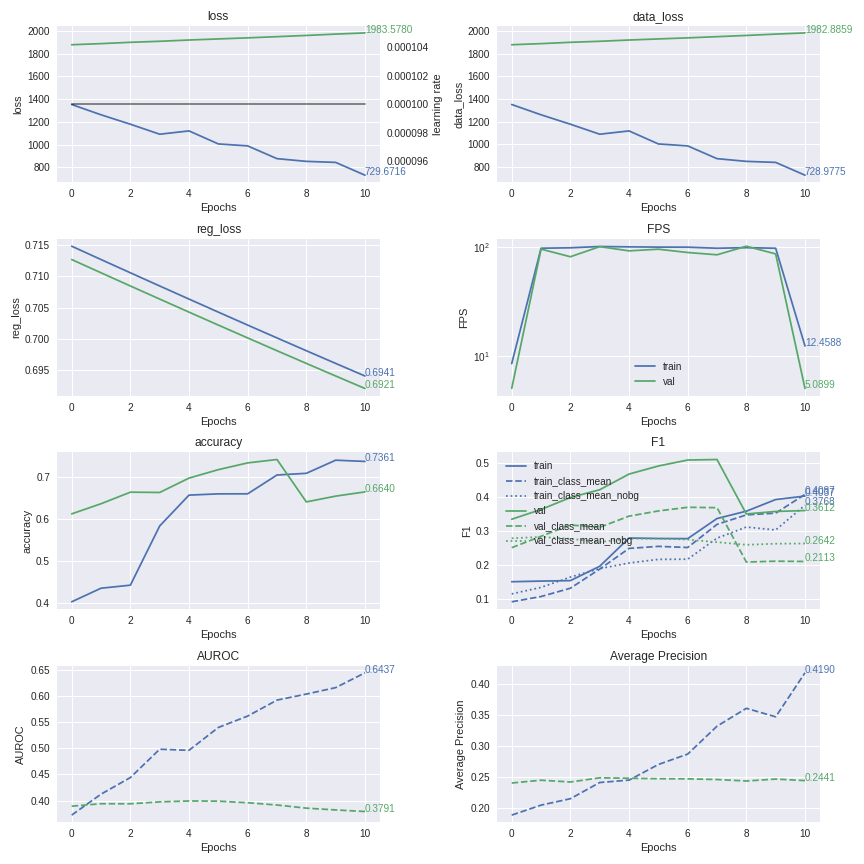

In [ ]:
model_path = os.path.join(project_path, 'models')
weights = projects.get_weights_from_model_path(model_path)
sequence_weights = weights['sequence']
# bthe sequence type is always tgmj, a slightly modified TGM model
latest_weights = sequence_weights['tgmj'][-1]
# our run directory is two steps above the weight file
run_dir = os.path.dirname(os.path.dirname(latest_weights))
assert os.path.isdir(run_dir), 'run directory not found! {}'.format(run_directory)

figure_dir = os.path.join(run_dir, 'figures')
figure_files = utils.get_subfiles(figure_dir, 'file')
assert len(figure_files) >= 1

Image(figure_files[0])

# Sequence inference

Now that we have our sequence model, we want to run it for all frames for all videos. We will use the correct number of cpus, and make sure we load up the latest sequence model weights. Note: with any GPU, this should be virtually instantaneous.

**equivalent command line args**: `python -m deepethogram.sequence.inference sequence.weights=latest compute.num_workers=2 inference.overwrite=True inference.ignore_error=False` (should be straightforward by now)

In [ ]:
cfg = configuration.make_sequence_inference_cfg(project_path)
cfg.sequence.weights = 'latest'
cfg.compute.num_workers = n_cpus
cfg.inference.overwrite = True
cfg.inference.ignore_error = False

sequence_inference(cfg)

[2022-06-08 01:13:24,986] INFO [deepethogram.projects.convert_config_paths_to_absolute:1135] cwd in absolute: /content/drive/MyDrive/Public/testing_deepethogram/models/220608_011110_sequence_train
[2022-06-08 01:13:24,993] INFO [deepethogram.projects.convert_config_paths_to_absolute:1178] after absolute: {'class_names': ['background', 'face_groom', 'body_groom', 'dig', 'scratch'], 'config_file': '/content/drive/MyDrive/Public/testing_deepethogram/project_config.yaml', 'data_path': '/content/drive/MyDrive/Public/testing_deepethogram/DATA', 'labeler': None, 'model_path': '/content/drive/MyDrive/Public/testing_deepethogram/models', 'name': 'testing', 'path': '/content/drive/MyDrive/Public/testing_deepethogram', 'pretrained_path': '/content/drive/MyDrive/Public/testing_deepethogram/models/pretrained_models'}
[2022-06-08 01:13:25,020] INFO [deepethogram.sequence.inference.sequence_inference:230] args: /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter

TGMJ(
  (input_dropout): Dropout(p=0.5, inplace=False)
  (output_dropout): Dropout(p=0.5, inplace=False)
  (tgm_layers): Sequential(
    (0): TGMLayer()
    (1): TGMLayer()
    (2): TGMLayer()
  )
  (h): Conv1d(1024, 128, kernel_size=(1,), stride=(1,))
  (h2): Conv1d(1024, 128, kernel_size=(1,), stride=(1,))
  (classify1): Sequential(
    (0): Conv1d(128, 5, kernel_size=(1,), stride=(1,), bias=False)
    (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classify2): Sequential(
    (0): Conv1d(128, 5, kernel_size=(1,), stride=(1,), bias=False)
    (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)




  0%|          | 0/7 [00:00<?, ?it/s][2022-06-08 01:13:26,137] INFO [deepethogram.sequence.inference.extract:196] running inference on /content/drive/MyDrive/Public/testing_deepethogram/DATA/mouse00/mouse00_outputs.h5. latent name: resnet18 output name: tgmj...


 14%|█▍        | 1/7 [00:00<00:00,  6.53it/s][2022-06-08 01:13:26,304] INFO [deepethogram.sequence.inference.extract:196] running inference on /content/drive/MyDrive/Public/testing_deepethogram/DATA/mouse01/mouse01_outputs.h5. latent name: resnet18 output name: tgmj...


 29%|██▊       | 2/7 [00:00<00:00,  5.02it/s][2022-06-08 01:13:26,538] INFO [deepethogram.sequence.inference.extract:196] running inference on /content/drive/MyDrive/Public/testing_deepethogram/DATA/mouse02/mouse02_outputs.h5. latent name: resnet18 output name: tgmj...


 43%|████▎     | 3/7 [00:00<00:00,  4.98it/s][2022-06-08 01:13:26,742] INFO [deepethogram.sequence.inference.extract:196] running inference on /content/drive/MyDrive/Public/testing_deepethog

## Checkout the new inference data in the HDF5 file

The sequence inference process found our HDF5 files with feature vectors in them, and added a new group to store our data in.

In [ ]:
# this just parses our DATA directory, to get the path to each file for each video
records = projects.get_records_from_datadir(os.path.join(project_path, 'DATA'))
animal = random.choice(list(records.keys()))
record = records[animal]

# I call the file output by inference the `outputfile` in various places in the code
outputfile = record['output']

utils.print_hdf5(outputfile)

resnet18
|--- P: (300, 5) float32
|--- class_names: (5,) object
|--- flow_features: (300, 512) float32
|--- logits: (300, 5) float32
|--- spatial_features: (300, 512) float32
|--- thresholds: (5,) float32
tgmj
|--- P: (300, 5) float32
|--- class_names: (5,) object
|--- logits: (300, 5) float32
|--- thresholds: (5,) float32
attrs: 


Note that the name of the group is `tgmj`, because that's the sequence model architecture we're using. If you're feeling adventurous, you can try to use simple 1D convolutional networks or RNNs like LSTMs, all through the command line or the configuration.

We can load the new probabilities and thresholds as before:

In [ ]:
# we use the h5py package for this
with h5py.File(outputfile, 'r') as f:
  probabilities = f['tgmj/P'][:]
  thresholds = f['tgmj/thresholds'][:]
# n frames x K behaviors
print(probabilities.shape)
print(thresholds)

(300, 5)
[0.01       0.24630654 0.07546934 0.5        0.5       ]


# Convert all our sequence probabilities into binary predictions, and save to .csv files

As before, we'll make a new configuration. This is necessary because there are multiple types of postprocessors I've implemented-- simple thresholding, setting a minimum bout length for each behavior bout (e.g. 2 frames), or, as is now the default, making the minimum bout length for each behavior the 1st percentile of the observed bout length distribution.

In [ ]:
cfg = configuration.make_postprocessing_cfg(project_path=project_path)

This cell will iterate through all the files in your dataset, load up the correct probabilities and thresholds, and export the predictions to a .csv file.

Note that if you wanted to export the predictions of our feature extractor models, you could edit it as follows:
`cfg.sequence.output_name='resnet18'`

In [ ]:
postprocessing.postprocess_and_save(cfg)

[2022-06-08 01:13:39,960] INFO [deepethogram.projects.convert_config_paths_to_absolute:1135] cwd in absolute: /content/drive/MyDrive/Public/testing_deepethogram/models/220608_011324_sequence_inference
[2022-06-08 01:13:39,967] INFO [deepethogram.projects.convert_config_paths_to_absolute:1178] after absolute: {'class_names': ['background', 'face_groom', 'body_groom', 'dig', 'scratch'], 'config_file': '/content/drive/MyDrive/Public/testing_deepethogram/project_config.yaml', 'data_path': '/content/drive/MyDrive/Public/testing_deepethogram/DATA', 'labeler': None, 'model_path': '/content/drive/MyDrive/Public/testing_deepethogram/models', 'name': 'testing', 'path': '/content/drive/MyDrive/Public/testing_deepethogram', 'pretrained_path': '/content/drive/MyDrive/Public/testing_deepethogram/models/pretrained_models'}


You can now navigate to the right location in your Google drive and look at the file the ends with `_predictions.csv` in each of your data directories.

Alternatively, we can load a random one with Pandas and see what's in it:

In [ ]:
# load a random record
records = projects.get_records_from_datadir(os.path.join(project_path, 'DATA'))
animal = random.choice(list(records.keys()))
record = records[animal]
# figure out the filename
predictions_filename = os.path.join(os.path.dirname(record['rgb']), record['key'] + '_predictions.csv')
assert os.path.isfile(predictions_filename)

# read csv
df = pd.read_csv(predictions_filename, index_col=0)
# display outputs
df.head()

,background,face_groom,body_groom,dig,scratch
0,0,0,1,0,1
1,0,0,1,0,1
2,0,0,1,0,1
3,0,0,1,0,1
4,0,0,1,0,1


And, you're done! Every video now has a binary output for every frame in a simple, readable .csv file.

# Next steps

If this works OK for your project, the next steps should be to get a computer with a good GPU locally. When I began this project, this was not a hard step! However, due to the silicon shortage it might be very hard or expensive. Note that GPUs <$1000, such as an old 1080 Ti, or an Nvidia 3080, are going to be multiple *times* faster than a K80 or T4 that Google might give you for free.


## colab workflow
If you can't convince your PI to spend the money, or you can't find any GPU at a reasonable price, here is what I would suggest as a workflow:

1. Run first experiments, collect video.
2. Label videos on your laptop with the DeepEthogram GUI.
3. Convert videos (see top of this notebook)
4. Upload to your Google drive
5. Use this notebook, or just the code samples, to train and run inference on all models. You should use your judgment when to train the flow generators. For the others, for any significant addition of data, I would recommend re-training the feature extractor, running inference, train the sequence model, and run inference. Again, the sequence model only adds a few minutes to the workflow. **Note: you might have your Runtime interrupted by Google. In that case, you'll have to re-start the training process where it left off.**
6. Run more experiments, *don't label videos yet*
7. convert and upload videos
8. run feature extractor and sequence inference
9. Download all the new files to your local computer (very slow probably)
10. Use the predictions to edit the (hopefully rare) mistakes on mistakes on unlabeled videos
11. Step 5 again: re-train models and re-run inference

## Local workflow
However, I continue to think that a local workstation with a good Nvidia GPU makes a lot of sense. With a local workstation, the workflow is similar. However, by removing downloading and uploading steps, you'll save a lot of time. Furthermore, you can use the GUI for the whole thing-- so you can just add a new video, click the `inference` button twice, and have predictions there ready-to-go. Finally, you'll never be pre-empted, so you won't be interrupted in the middle of training.

1. Run first experiments, collect video.
2. Label videos on your laptop with the DeepEthogram GUI.
3. Convert videos (see top of this notebook)
4. Use the examples in this notebook to write your own code; or just click the buttons on the GUI to train all models and run inference.
5. Run more experiments, *don't label videos yet*
6. (optional) convert videos
7. run feature extractor and sequence inference
8. The predictions are already generated. Use the GUI to re-label mistakes.
9. GOTO step 4

About GPU cost:
`<step on soapbox>` Besides, PIs, lab managers, and funding agencies need to start seeing computational resources as a fundamental part of biological research. If DeepEthogram can manage to save you many hours of your time, how much money is that worth to you, your lab, and science overall? Surely enough to justify the money on a GPU. Furthermore, I'm not getting the money, Nvidia is :/. I just hope that this package saves you time and effort, and enables you to ask questions that are too labor-intensive with only human labeling. `</step on soapbox>`


# Questions?

If you have any issues, or can't get this notebook to run, or just have questions, please raise an issue on Github. This is more useful than emailing me, because other people can learn from our public debugging if they have similar issues.

https://github.com/jbohnslav/deepethogram/issues